In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from functools import reduce

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import DataPreprocessing

In [2]:
##Obtain & process data NPY
me_train, mom_train = DataPreprocessing.npy('NLO/MG_uuxg/me_1000000.npy', 'NLO/MG_uuxg/mom_1000000.npy', [], frac=1)
me_test, mom_test = DataPreprocessing.npy('NLO/MG_uuxg/me_100000.npy', 'NLO/MG_uuxg/mom_100000.npy', [], frac=1)

In [3]:
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(['1,3','2,3'], mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    pyplot.savefig('KBinsAtNLO')

Born RMSE: 9.257450753419672
Born Percentage Error: 0.010509130918361597
Finite RMSE: 3938.8556259740376
Finite Percentage Error: 98.2966807064825
Sing RMSE: 590.4868779812919
Sing Percentage Error: 3.53648485691553
Doub RMSE: 0.7266631590039127
Doub Percentage Error: 0.010509130928934551


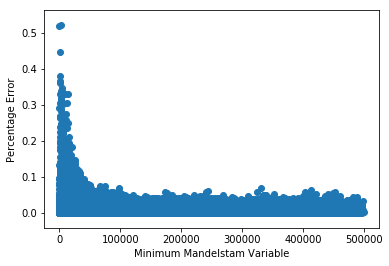

In [5]:
def calc_RMSE(mom_train, mom_test, me_train, me_test, var_name):
    ##Data transformation
    mom_train_flat = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train])
    mom_test_flat = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test])

    pipeline = Pipeline([
        
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=8000)) #Checking convergence as bins.
    ])
 
    mom_train_flat = pipeline.fit_transform(mom_train_flat) #Rescale on training set
    mom_test_flat = pipeline.transform(mom_test_flat) #Rescale on test set

    
    linreg = LinearRegression().fit(mom_train_flat, me_train) #Linear fit
    pred = linreg.predict(mom_test_flat) #Prediction on test set
    
    mse = mean_squared_error(me_test, pred) #Mean squared error on test set
    print('{} RMSE: {}'.format(var_name, np.sqrt(mse)))

    perc = np.mean(100*np.divide(np.abs(me_test - pred), abs(me_test)))
    print('{} Percentage Error: {}'.format(var_name, perc))
    
    if var_name=='Born':
        #error_plot(np.abs(100*np.divide(np.abs(me_test - pred), me_test)))
        error_smallest_S(np.abs(100*np.divide(np.abs(me_test - pred), me_test)), mom_test)
    
for i, name in enumerate(['Born', 'Finite', 'Sing', 'Doub']):
    div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
    div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))

    temp_train = np.multiply(div_train, me_train[:,i])
    temp_test = np.multiply(div_test, me_test[:,i])
        
    calc_RMSE(mom_train, mom_test, temp_train, temp_test, name)

Plotting Learning Curve

## Accuracy Vs Number of Bins